## Hands-on session 2.2 - Variable-like modelbound data

This short sessions takes a break from plasma physics as we play around with the [predator-prey model](https://en.wikipedia.org/wiki/Lotka%E2%80%93Volterra_equations). 

Demonstrated concepts:

- 0D simulations with ReMKiT1D
- Variable-like modelbound data
- Automatic generation of modelbound data using nodes
- Setting time target integration
- Using RK4 and setting term groups
- Building a simple composite integrator

In [1]:
from RMK_support import RKWrapper ,Grid, Node, treeDerivation
import RMK_support.simple_containers as sc
import RMK_support.IO_support as io
import RMK_support.dashboard_support as ds
import RMK_support.common_models as cm

import numpy as np
import holoviews as hv 
import panel as pn
import matplotlib.pyplot as plt


### Wrapper initialization

In [2]:
rk = RKWrapper()

### Global parameters for writing the files

In [3]:
rk.jsonFilepath = "./config.json" # Default value
hdf5Filepath = "./RMKOutput/day_2_2/"
rk.setHDF5Path(hdf5Filepath) 

### Grid initialization

We initialize a trivial 0D grid

In [4]:
rk.grid = Grid(np.zeros(1))

### The equations

The predator-prey system can be written as follows:

$$ \frac{dx}{dt} = (\alpha - \beta y)x $$
$$ \frac{dy}{dt} = (\delta x - \gamma)y $$

where $\alpha$ and $\beta$ are the prey growth and death factors, and $\delta$ and $\gamma$ are the predator growth and death factors. $x$ and $y$ are prey and predator numbers in arbitrary units.

### Variables

We just need the implicit predator and prey variables, and can also set the 4 constants while we're at it. Let's also set two more copies of x and y so we can build the model in two ways.

**NOTE**: The `x` name is reserved for the grid, so we do not use it for variables. Use x1,y1,x2,y2.

Initialize both of the x variables to 10, and both the y variables to 2 (remember, they should be numpy arrays with the length of the grid!)

Do not forget to add the `time` derived scalar variable. We will explicitly need it in this session.

In [5]:
# [YOUR CODE HERE]
rk.addVar("x1", np.ones(1)*10)
rk.addVar("x2", np.ones(1)*10)
rk.addVar("y1", np.ones(1)*2)
rk.addVar("y2", np.ones(1)*2)
rk.addVar("time", isScalar=True, isDerived=True)

alpha = 1.1
beta = 0.4
delta = 0.1
gamma = 0.4

### The model - general

We can build the model in two ways because of its structure. The general way comes first, where we introduce modelbound data by hand.

Let's first add the derivations we need to the wrapper. These should evaluate to the bracketed values in the equations.

Use the `addCustomDerivation` method on the wrapper to add the two derivations, and add the derivations using the `treeDerivation` function and using `Node` where necessary. Use the first two variables here (x1,y1)!

In [6]:
# NOTE: no nodes needed for scalars. Alpha, beta etc are just constants that don't live in ReMkIT
rk.addCustomDerivation("xDeriv", derivOptions=treeDerivation(alpha - beta * Node("y1")))
rk.addCustomDerivation("yDeriv", derivOptions=treeDerivation(delta * Node("x1") - gamma))

Let's then build a model for the predator-prey equations and create the modelbound data that goes with it

Use `sc.VarlikeModelboundData` and the corresponding `addVariable` methods. Do not forget to call `setModelboundData` (you'll need to call `dict()` on the modelbound data object before passing it to the wrapper)

In [7]:
# NOTE: this is in the example in the slides

predPreyModel = sc.CustomModel("predatorPrey")

mbData = sc.VarlikeModelboundData()
mbData.addVariable(
    "xCoeff",
    derivationRule=sc.derivationRule("xDeriv", ["y1"]
    )
)

mbData.addVariable(
    "yCoeff",
    derivationRule=sc.derivationRule("yDeriv", ["x1"]
    )
)

# You're adding to the model, not to the wrapper.
predPreyModel.setModelboundData(mbData.dict())

# [YOUR CODE HERE]


Let's now add the two simple terms by hand

Take the modelbound variables you added and use them as `reqMBRowVars`

In [8]:
xTerm = sc.GeneralMatrixTerm("x1",
                             varData=sc.VarData(reqMBRowVars=["xCoeff"]),
                             stencilData=sc.diagonalStencil())

predPreyModel.addTerm("xTerm",xTerm)

yTerm = sc.GeneralMatrixTerm("y1",
                             varData=sc.VarData(reqMBRowVars=["yCoeff"]),
                             stencilData=sc.diagonalStencil(),
                             implicitGroups=[2]) # See note below

predPreyModel.addTerm("yTerm",yTerm)

rk.addModel(predPreyModel)

Checking terms in model predatorPrey:
   Checking term xTerm
   Checking term yTerm


**NOTE**: 

Term groups: We can have finer control over time integration by setting term groups. This is particularly important when using the explicit RK integrators, as they will skip any mixed term groups - groups of terms with different evolved variables. A way to avoid worrying about this is not to have models which evolve more than 1 variable.

### The model - a faster way

As noted above, because the structure of our equations looks like rowVariable * implicitVariable, we can use the `addNodeMatrixTermModel` function from `common_models` to automatically add the modelbound variables and the terms

The `termDefs` below are missing the `Node` objects they should use for the derivation. These should be the same objects as the ones you used above. Make sure they use the correct variables (x2,y2)!

In [9]:
# Implicit variable is the one outside of the bracket, the row variable is the bracket.
# This is because of matrix stuff
# NOTE that a root node is still a node, so an expression using nodes is itself a node.

cm.addNodeMatrixTermModel(rk,
                          modelTag="predatorPreyQuickerX",
                          evolvedVar="x2",
                          termDefs=[(alpha - beta * Node("y2"),"x2")]) #[YOUR CODE HERE]

cm.addNodeMatrixTermModel(rk,
                          modelTag="predatorPreyQuickerY",
                          evolvedVar="y2",
                          termDefs=[(delta * Node("x2") - gamma,"y2")]) #[YOUR CODE HERE]

Checking terms in model predatorPreyQuickerX:
   Checking term nodeTerm_0
Checking terms in model predatorPreyQuickerY:
   Checking term nodeTerm_0


### Setting up the time integration options

The predator-prey model is a good place to showcase the different behaviour of the two time integrators available. The RK integrator goes up to fourth order, while the Backwards Euler integrator is first order. 

We can use ReMKiT1D's composite integrator feature to add multiple integrators and split integration so that different models are evolved using different integrators. 

Let's first add the integrators:

In [10]:
integratorRK = sc.rkIntegrator(4) # Play around with the order value for RK to see how the solution is affected
integratorBDE = sc.picardBDEIntegrator(nonlinTol=1e-14,absTol=10.0, convergenceVars=["x2","y2"])

rk.addIntegrator("RK", integratorRK)
rk.addIntegrator("BE", integratorBDE)

Unlike in previous sessions, we have split the terms of one of our models into two groups. So we need to tell the composite integrator to expect two groups.

In [11]:
rk.setIntegratorGlobalData(initialTimestep=0.01,numImplicitGroups=2) # We tell the integrators to expect 2 implicit groups

Let's add the RK step. By default, all steps are applied for the full duration of the time step, and since we aren't doing operator splitting, we'll keep this behaviour.

However, the `predatorPrey` model has two implict term groups, so we need to tell the integration step to update and evaluate both.

In [12]:
rkStep = sc.IntegrationStep("RK",defaultEvaluateGroups=[1,2],defaultUpdateGroups=[1,2]) # Tell the RK step to update and evaluate terms in both groups

rkStep.addModel("predatorPrey")

rk.addIntegrationStep("RK1", rkStep.dict())

The Backwards Euler integrator should handle the other two models

In [13]:
bdeStep = sc.IntegrationStep("BE") # The other two models don't have their terms split into groups

bdeStep.addModel("predatorPreyQuickerX")
bdeStep.addModel("predatorPreyQuickerY")

rk.addIntegrationStep("BE1", bdeStep.dict())


Let's run the predator-prey model up to t=50. We can move from using a fixed number of timesteps to asking the code to run until some minimum time has elapsed. We can also set the output option to write files with a fixed minimum time interval between them.

In [14]:
rk.setTimeTargetTimestepping(50.0) # Run until 50 time units have elapsed
rk.setMinimumIntervalOutput(0.1) # Output every 0.1 time unit (might not have exactly 500 files because of rounding)

### Create config 

Remember to run ReMKiT1D with a single MPI process for this session.

In [15]:
rk.writeConfigFile()

### Data analysis

In [17]:
hv.extension('matplotlib')
%matplotlib inline 
plt.rcParams['figure.dpi'] = 150
hv.output(size=100,dpi=150)

numFiles=471
loadpath = rk.hdf5Filepath
loadFilenames = [loadpath+f'ReMKiT1DVarOutput_{i}.h5' for i in range(numFiles+1)]
loadedData = io.loadFromHDF5(rk.varCont, filepaths=loadFilenames)
loadedData


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W

<xarray.Dataset>
Dimensions:  (x: 1, h: 1, v: 1, time: 472)
Coordinates:
  * x        (x) float64 0.0
  * h        (h) int64 0
  * v        (v) float64 1.0
  * time     (time) float64 0.0 0.11 0.21 0.31 0.41 ... 49.69 49.8 49.91 50.01
Data variables:
    x1       (time, x) float64 10.0 10.3 10.53 10.7 ... 4.495 4.806 5.137 5.455
    x2       (time, x) float64 10.0 10.3 10.52 10.69 ... 5.715 6.061 6.418 6.75
    y1       (time, x) float64 2.0 2.14 2.282 2.438 ... 1.222 1.231 1.244 1.26
    y2       (time, x) float64 2.0 2.141 2.283 2.44 ... 1.404 1.434 1.47 1.509

### Comparing the integrators

As you can see below, with the same step length, the higher order RK integrator is not as dissipative as the implicit integrator, as expected.

:HoloMap   [x]
   :Overlay
      .Curve.X1 :Curve   [time]   (x1)
      .Curve.Y1 :Curve   [time]   (y1)
      .Curve.X2 :Curve   [time]   (x2)
      .Curve.Y2 :Curve   [time]   (y2)
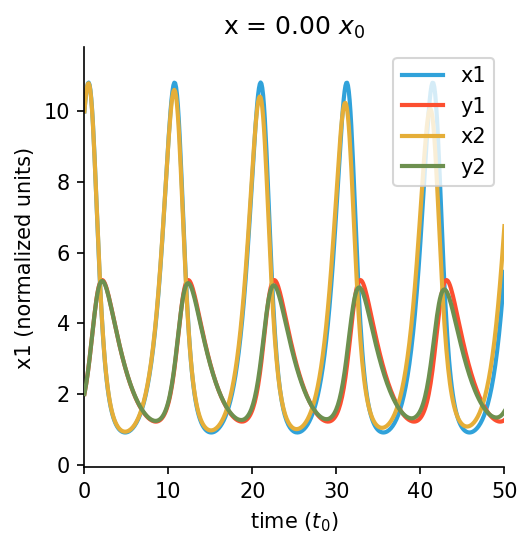

In [18]:
pn.extension(comms="vscode") # change comms if not using VSCode
dashboard = ds.ReMKiT1DDashboard(loadedData,rk.grid)

dashboard.fluidMultiComparison(["x1","y1","x2","y2"],fixedPosition=True)

Text(0.5, 0, 'x')

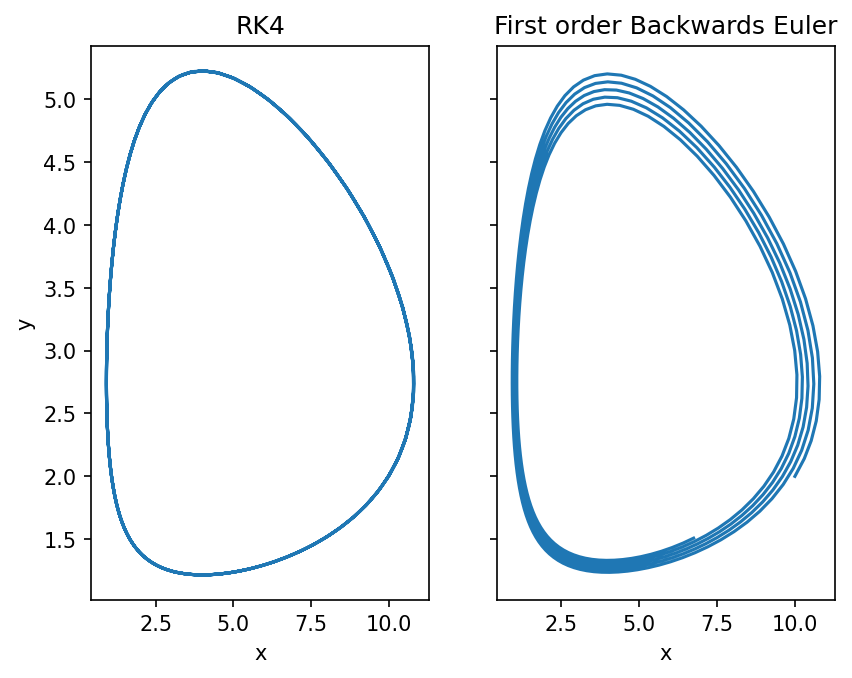

In [19]:
fig,ax = plt.subplots(1,2,sharey="row")

ax[0].plot(loadedData["x1"],loadedData["y1"])

ax[0].title.set_text("RK4")

ax[0].set_xlabel("x")
ax[0].set_ylabel("y")

ax[1].plot(loadedData["x2"],loadedData["y2"])

ax[1].title.set_text("First order Backwards Euler")

ax[1].set_xlabel("x")
